#Bayesian SN Cosmology

[Rubin et al. 2015](http://arxiv.org/abs/1507.01602) lays out a pretty complete Bayesian model for going from light curve parameters for a large, heterogeneous set of SNe to inferred cosmological parameters. However, it has a couple deficiencies: (1) There's no publicly available code, meaning that the model cannot be modified and improved. (2) The implementation runs slowly (timescale of days). In this hack, we'll start on an open-source package implementing the model and seeing if we can take advantage of aspects of the problem to make it run a whole lot faster.

##Simplistic Model

In [ ]:
from scipy import stats
import numpy as np
import sncosmo
import daft
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

%matplotlib inline

In [ ]:
from matplotlib import rc
#rc("font", family="serif", size=12)
#rc("text", usetex=True)

pgm = daft.PGM([7, 5], origin=[-1.5, 1])
pgm.add_node(daft.Node("alpha", r"${\alpha}$", 2.3, 5))
pgm.add_node(daft.Node("beta", r"${\beta}$", 3.1, 5))
pgm.add_node(daft.Node("Mb", r"$M_{B}$", 3.9, 5))
pgm.add_node(daft.Node("sigma", r"${\sigma_{\mathrm{int}}}$", 4.7, 5))
pgm.add_node(daft.Node("Omega", r"$\Omega$", 0, 4))
pgm.add_node(daft.Node("mu", r"$\mu_{k}$", 1.05, 4, fixed=True))
pgm.add_node(daft.Node("mbtrue", r"$m^{\mathrm{true}}_{B,k}$", 3.5, 4))
pgm.add_node(daft.Node("mbobs", r"$m^{\mathrm{obs}}_{B,k}$", 5, 4, observed=True))
pgm.add_node(daft.Node("ctrue", r"$c^{\mathrm{true}}_{k}$", 3.1, 3.3))
pgm.add_node(daft.Node("xtrue", r"$x^{\mathrm{true}}_{1,k}$", 3.9, 3.3))
pgm.add_node(daft.Node("cobs", r"$c^{\mathrm{obs}}_{k}$", 2.5, 2.6, observed=True))
pgm.add_node(daft.Node("xobs", r"$x^{\mathrm{obs}}_{1,k}$", 4.5, 2.6, observed=True))
pgm.add_node(daft.Node("cdist", r"$c^{\mathrm{dist}}$", 3.1, 1.6, fixed=True))
pgm.add_node(daft.Node("xdist", r"$x^{\mathrm{dist}}$", 3.9, 1.6, fixed=True))
pgm.add_node(daft.Node("z", r"$z_k$", 1.05, 3, observed=True))
pgm.add_plate(daft.Plate([0.5, 2.15, 5, 2.3],
        label=r"supernovae $k$"))
pgm.add_edge("alpha", "mbtrue")
pgm.add_edge("beta", "mbtrue")
pgm.add_edge("Mb", "mbtrue")
pgm.add_edge("sigma", "mbtrue")
pgm.add_edge("Omega", "mu")
pgm.add_edge("mu", "mbtrue")
pgm.add_edge("mbtrue", "mbobs")
pgm.add_edge("ctrue", "mbtrue")
pgm.add_edge("xtrue", "mbtrue")
pgm.add_edge("ctrue", "cobs")
pgm.add_edge("xtrue", "xobs")
pgm.add_edge("cdist", "ctrue")
pgm.add_edge("xdist", "xtrue")
pgm.add_edge("z", "mu")
pgm.render()
pgm.figure.savefig("bayesianSNcosmology.pdf")
#pgm.figure.savefig("bayesianSNcosmology.png", dpi=150)

<img src="bayesianSNcosmology.png" style="width: 7in;">

In [9]:
"""
class variable(object):
    
    '''Random variables: they have names, values, and can be histogrammed.'''
    
    def __init__(self,names):
        self.names = np.atleast_1d(names)
        self.Ndim = len(self.names)
        self.values = np.zeros(self.Ndim,)
        return
    
    def __str__(self):
        return string.join(self.names,',')
    
    def histogram(self):
        print "Histograms coming soon!"
        return
"""

'\nclass variable(object):\n    \n    \'\'\'Random variables: they have names, values, and can be histogrammed.\'\'\'\n    \n    def __init__(self,names):\n        self.names = np.atleast_1d(names)\n        self.Ndim = len(self.names)\n        self.values = np.zeros(self.Ndim,)\n        return\n    \n    def __str__(self):\n        return string.join(self.names,\',\')\n    \n    def histogram(self):\n        print "Histograms coming soon!"\n        return\n'

In [10]:
"""
class probability(object):
    
    '''Conditional probability distribution, Pr(A|B). 
       The value of this PDF at a particular A is a "probability density."
       Evaluating the density as a function of B gives the "likelihood".'''

    def __init__(self,of=None,given=None,assumptions=None):

        # We must have defined our dependent and independent variables,
        # and one cannot do inference without making assumptions:
        assert assumptions is not None
        assert of is not None
        assert given is not None
        
        self.assumptions = assumptions  # stored as a dictionary
        self.A = of                     # a list of variables
        self.B = given                  # another list of variables
        
        return
    
    def __str__(self):
        return "$Pr({A}|{B})$".format(A=str(self.A), B=str(self.B))
        
    def draw(self,N):
        '''Draw N sample values of A, given B and our assumptions.'''
        self.samples = generator(N,self.assumptions,self.B)
        return
    
    def evaluate(self):
        return density(self.A,self.B,assumptions)
"""

'\nclass probability(object):\n    \n    \'\'\'Conditional probability distribution, Pr(A|B). \n       The value of this PDF at a particular A is a "probability density."\n       Evaluating the density as a function of B gives the "likelihood".\'\'\'\n\n    def __init__(self,of=None,given=None,assumptions=None):\n\n        # We must have defined our dependent and independent variables,\n        # and one cannot do inference without making assumptions:\n        assert assumptions is not None\n        assert of is not None\n        assert given is not None\n        \n        self.assumptions = assumptions  # stored as a dictionary\n        self.A = of                     # a list of variables\n        self.B = given                  # another list of variables\n        \n        return\n    \n    def __str__(self):\n        return "$Pr({A}|{B})$".format(A=str(self.A), B=str(self.B))\n        \n    def draw(self,N):\n        \'\'\'Draw N sample values of A, given B and our assumptions.\'\

In [11]:
"""
def generator(N,model,parameters):
    #if distribution is Gaussian
    #else if mixture
    return None
"""

'\ndef generator(N,model,parameters):\n    #if distribution is Gaussian\n    #else if mixture\n    return None\n'

In [12]:
"""
def density(N,model,parameters):
    if "Sampling coming soon!"
    return None
"""

'\ndef density(N,model,parameters):\n    if "Sampling coming soon!"\n    return None\n'

In [13]:
"""parameters = variable(['mu','sigma'])
I = {'functional_form':'Gaussian'}
pdf = probability(of=data,given=parameters,assumptions=I)
print pdf
"""

"parameters = variable(['mu','sigma'])\nI = {'functional_form':'Gaussian'}\npdf = probability(of=data,given=parameters,assumptions=I)\nprint pdf\n"

##Assigning Probability Distributions

This is mostly just following the Rubin et al. 2015 explanation, quoted below...

"Each simulated dataset has 250 SNe, except the highest-redshift, which has 50."

In [105]:
size_we_want = 250

"We generate the $x_{1}$ population from a unit normal distribution, centered on zero."

In [106]:
x1_eval_pts = np.linspace(-5,5,num=size_we_want)

x1_dist = stats.norm(loc=0, scale=1)
x1_true_draw = x1_dist.rvs(size_we_want)
x1_true_eval = x1_dist.pdf(x1_eval_pts)
x1_dist

"We assume that the uncertainties on $m_B$, $x_{1}$, and $c$ are 0.05, 0.5, and 0.05, and are uncorrelated."

In [107]:
x1_obs_unc = 0.5*np.ones_like(size_we_want)

x1_obs_draw = x1_true_draw + x1_obs_unc*x1_true_draw
x1_obs_eval = x1_true_eval + x1_obs_unc*x1_true_eval

"We draw the population $c$ values from the sum of a Gaussian distribution of width 0.1 magnitudes and an exponential with rate 1/(0.1 magnitudes). We center the distribution on zero." $\beta$ is the scale parameter, which is the inverse of the rate parameter $\lambda = 1/\beta$.  The rate parameter is an alternative, widely used parameterization of the exponential distribution.

In [126]:
"""
x1_eval_pts = np.linspace(-5,5,num=size_we_want)

x1_true = stats.norm(loc=0, scale=1)
x1_true_draw = x1_true.rvs(size_we_want)
x1_true_eval = x1_true.pdf(x1_eval_pts)

"""

c_true = stats.norm(loc=0, scale=1)
c_true_draw = c_true.rvs(size_we_want)
c_true_eval = c_true.pdf(x1_eval_pts)

c_obs_unc = 0.5*np.ones_like(size_we_want)

c_obs_draw = c_true_draw + c_obs_unc*c_true_draw
c_obs_eval = c_true_eval + c_obs_unc*c_true_eval

"We generate four simulated datasets spanning the redshift ranges 0.02-0.05, 0.05-0.4, 0.2-1.0, and 0.7-1.4." We're just doing one set for now, from 0.2-1.0.

In [127]:
z = np.random.uniform(0.2, 1.0, size=size_we_want)

$\alpha$ and $\beta$ are assumed to be constant, with values 0.13 and 3.0, respectively. $M_{B}$ is set to -19.1 and $\Omega_{m}$ is set to 0.3 (flat $\Lambda \text{CDM}$ model).

In [144]:
alpha = 0.13
beta = 3.0
MB = -19.1
Omega_m = 0.3
sigma_int = 0.15

We calculated the $\mu$ values using astropy.cosmology.lambdacdm().

In [187]:
cosmo = FlatLambdaCDM(H0=70, Om0=Omega_m)

mu = cosmo.distmod(z).value
#mu = np.histogram(mu_draw)

#mu_eval = ??

"We assume that the intrinsic dispersion covariance matrix is correct in SALT2, and that only dispersion in $m_{B}$ (gray dispersion) remains. The statistical model does not have access to this information, and fits for the full unknown matrix, overestimating the uncertainties on $x_{1}$ and $c$, and thus slightly biasing $\alpha$ and $\beta$ away from zero (see Section 2.5). (This is not a unique problem for our framework; the old technique would have the same bias.)" We might come back to this but for now we just solved for $m_{B} = M_{B} - {\alpha}x_{1} + {\beta}{c} + \mu$ and introduced some scatter.

In [159]:
mb_true_draw = MB - alpha*x1_obs_draw + beta*c_obs_draw + mu \
+ np.random.normal(loc=0, scale=sigma_int, size=size_we_want) \
+ np.random.normal(loc=0, scale=0.05, size=size_we_want)

## Simple Monte Carlo Inference

If we were making mock data, we would do the following:

```python
    mb_obs_unc = 0.05*np.ones_like(mb_true_dist)

    mb_obs_dist = mb_true_dist + mb_obs_unc*np.random.normal(loc=0, scale=1, size=size_we_want)
```

However, right now we're going to get set up to do inference by Simple Monte Carlo: weight each sample by its parameters likelihood, and approximate posterior integrals with likelihood-weighted sums over prior samples.

In [160]:
# Let's package up the parameters, ML-style:

import pandas as pd
import scipy.stats

par_labels = ['alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']
len_par = len(par_labels)
truths = [0.13, 3.0, -19.1, 0.3, 0.15]
lim = [ [0., 1.], [2., 4.], [-25., -15.], [0., 1.], [0., 1.]]

In [181]:
nSN = 250

mb_obs = mb_true_draw[:nSN]
x1_obs = x1_obs_draw[:nSN]
c_obs = c_obs_draw[:nSN]
z_obs = z[:nSN]
obs = [mb_obs,x1_obs,c_obs,z_obs]

pos0 = np.zeros( ( len(par_labels) ))#+ 2*nSN) )   # this is here for the full model
pos0[:len_par] = truths  # This is cheaty, but we should start
                         # by getting the true values at least

array([  0.13,   3.  , -19.1 ,   0.3 ,   0.15])

In [182]:
def FlatPrior(p,l):
    """
        Flat Prior
    """
    if l[0] <= p <= l[1]:
        return np.log(1.0/(l[1] - l[0]))
    else:
        return -np.inf

    
def LogGaussian(x,mu,sig):
    return -0.5*(x-mu)**2 /sig**2

    
def LogLikelihood(datafr,obs):
    """
        Input:
            pandas dataframe with parameters
            observed values
        Return:
            Log likelihood
    """
    mb_obs,x1_obs,c_obs,z_obs = obs

    cosmo = FlatLambdaCDM(H0=70, Om0=datafr['Omega_m'])
    mu = cosmo.distmod(z_obs).value
    mb_true = datafr['MB'] - datafr['alpha']*x1_obs + datafr['beta'] * c_obs + mu + datafr['sigma_int']

    likelihood_mobs = LogGaussian(mb_obs, mb_true,0.05)
#    likelihood_x1 = LogGaussian(x1_obs, x1_true, 0.5)
#    likelihood_c = LogGaussian(c_obs, c_true, 0.5)
    
    return np.sum(likelihood_mobs)
    

def LogProb(pos,obs,lim):
    """
        Function needed in emcee. Given an array pos of parameters, returns the
        right-handside of Bayes equation (minus the normalisation Z)
        
        Input:
            array of parameters
            observed values
            limits of parameters used in the uniform priors
    """
    datafr = pd.Series(pos[:len_par],index=par_labels)
#    x1_true = pos[len_par::2]
#    c_true = pos[len_par+1::2]

    lp = 0.
    for p,l in zip(pos,lim):
        lp += FlatPrior(p,l)
        if not np.isfinite(lp):
            return -np.inf

    return lp +  LogLikelihood(datafr,obs)

LogProb(pos0,obs,lim)

-2522.00122591852

## Simple MC

In [177]:
%%time
N = 4000

schain = []# pd.DataFrame(np.ones((0,len(par_labels))),columns=par_labels)
for i in range(N):
#    mb_obs,x1_obs,c_obs,z_obs = obs
    datafr = pd.Series(np.zeros(len(par_labels)),index=par_labels,name=str(i))
    datafr['alpha'] = np.random.uniform(*lim[0])
    datafr['beta'] = np.random.uniform(*lim[1])
    datafr['MB'] = np.random.uniform(*lim[2])
    datafr['Omega_m'] = np.random.uniform(*lim[3])
    datafr['sigma_int'] = np.random.uniform(*lim[4])
#    x1_true = scipy.stats.norm.rvs(size=nSN)
#    c_true = scipy.stats.norm.rvs(size=nSN)

    datafr['weight'] = LogLikelihood(datafr,obs)
    
    schain.append(datafr)

schain = pd.DataFrame(schain)
unnormalized_likelihood = np.exp(schain['weight'] - np.max(schain['weight']))
schain.head()

CPU times: user 2min 41s, sys: 661 ms, total: 2min 41s
Wall time: 2min 40s


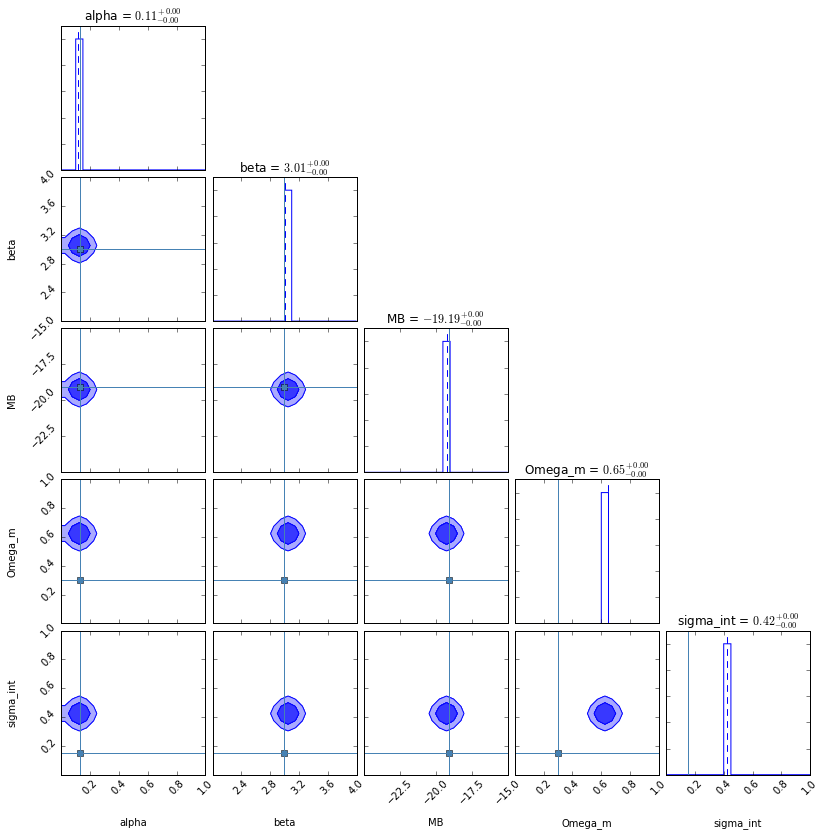

In [180]:
plt.close('all')
import corner
#rc("text", usetex=False)
fig = corner.corner(schain[par_labels], labels=par_labels, quantiles=[0.16,0.5,0.84],
                truths=truths, weights=unnormalized_likelihood,
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], 
                color='blue', smooth=1.0);
#fig.savefig('corner.png',dpi=300)

## Proper MCMC

In [183]:
%%time
import emcee
# set these values, in particular use lower niters for shorter chains and adjust
# the number of threads depending on the computer
nwalkers = 40
niters = 700
threads = 4

ndim = len_par
pos = [pos0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]   # gaussian

args = (obs,lim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogProb, args=args, threads=threads)
result = sampler.run_mcmc(pos, niters)
plt.plot(sampler.chain[:,:,0].T,c='b');

CPU times: user 7.84 s, sys: 1.94 s, total: 9.78 s
Wall time: 7min 41s


/home/marioaieie/.miniconda3/envs/astrohackweek/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


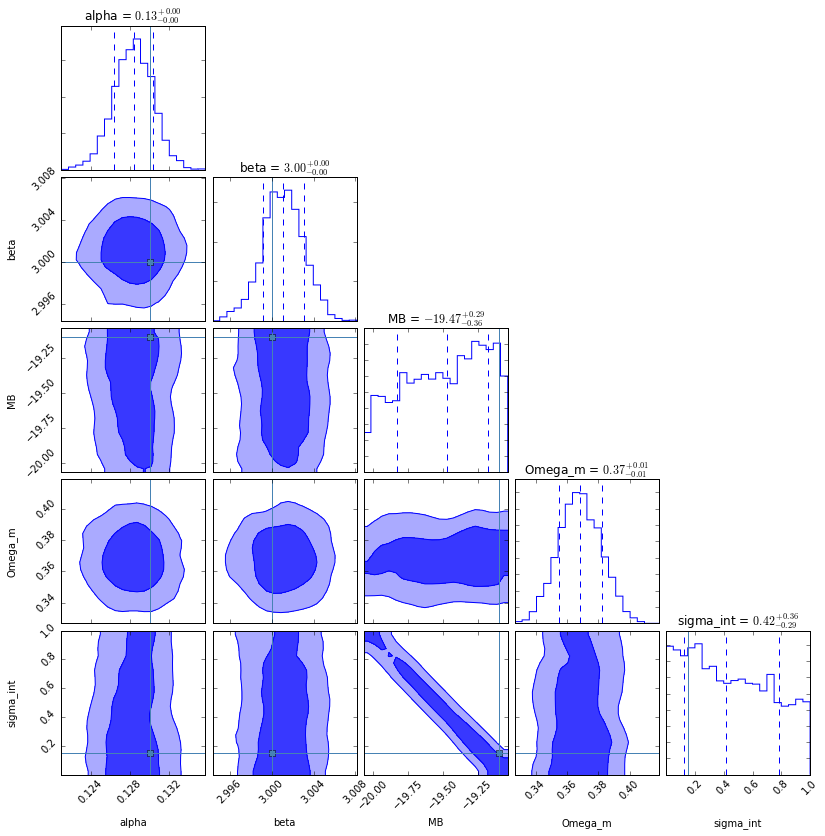

In [186]:
import corner
burn = 400
chain = sampler.chain[:,burn:,:].flatten().reshape(sampler.chain[:,burn:,:].size/len_par,len_par)
fig = corner.corner(chain, labels=par_labels, quantiles=[0.16,0.5,0.84],
                truths=truths, 
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], 
                color='blue', smooth=1.0);